In [ ]:
pip install PyMuPDF

In [ ]:
pip install pytesseract

In [ ]:
pip install scikit-learn

In [ ]:
pip install konlpy

In [ ]:
pip install wordcloud

In [ ]:
# company = "hanwha"

In [ ]:
# import re
# import pandas as pd
# from sklearn.feature_extraction.text import TfidfVectorizer
# from konlpy.tag import Okt

# # 1. 불용어 정의
# stopwords = set(['이', '그', '저', '등', '을', '를', '은', '는', '에', '의', '가', '도', '로', '과', '와', '해서', '하여', '고', '되며'])

# # 2. 형태소 분석기 초기화
# okt = Okt()

# # 3. 문장 분리 함수
# def split_sentences(text):
#     return [sent.strip() for sent in re.split(r'(?<=[.다])\s+', text) if sent.strip()]

# # 4. 전처리 함수 (불용어 제거 및 명사 추출)
# def preprocess_sentence(sentence):
#     words = okt.nouns(sentence)
#     return ' '.join([word for word in words if word not in stopwords and len(word) > 1])

# # 5. Chunk 불러오기
# with open(f"{company}_chunks.txt", encoding='utf-8') as f:
#     raw_data = f.read()

# chunks = [chunk.strip() for chunk in raw_data.split("Chunk ") if chunk.strip()]

# chunk_results = []

# for chunk in chunks:
#     chunk_id = chunk.split(":", 1)[0].strip()
#     content = chunk.split(":", 1)[1].strip()
    
#     sentences = split_sentences(content)
#     preprocessed = [preprocess_sentence(sent) for sent in sentences]
    
#     chunk_results.append({
#         'chunk_id': chunk_id,
#         'sentences': sentences,
#         'processed_sentences': preprocessed
#     })

# # 6. TF-IDF 계산
# all_docs = [' '.join(c['processed_sentences']) for c in chunk_results]
# vectorizer = TfidfVectorizer()
# tfidf_matrix = vectorizer.fit_transform(all_docs)
# terms = vectorizer.get_feature_names_out()

# # 7. 핵심 키워드 추출
# keywords_per_chunk = []

# keywords_per_chunk = []

# for idx, chunk in enumerate(chunk_results):
#     tfidf_scores = tfidf_matrix[idx].toarray()[0]
    
#     # 문장 수에 따라 추출할 키워드 수 결정
#     num_sentences = len(chunk['sentences'])
#     if num_sentences <= 5:
#         top_n = 8
#     elif num_sentences <= 10:
#         top_n = 15
#     elif num_sentences <= 20:
#         top_n = 30
#     elif num_sentences <= 30:
#         top_n = 35
#     else:
#         top_n = 40
    
#     # TF-IDF 점수 기반 상위 키워드 추출
#     top_indices = tfidf_scores.argsort()[-top_n:][::-1]
#     top_keywords = [(terms[i], tfidf_scores[i]) for i in top_indices if tfidf_scores[i] > 0]

#     keywords_per_chunk.append({
#         'chunk_id': chunk['chunk_id'],
#         'top_keywords': top_keywords
#     })


# # 간단한 문장 전처리 함수 + 길이 필터링
# def clean_sentence(sentence):
#     # 특수문자 제거, 여백 정리
#     sentence = re.sub(r'[^\w\s가-힣]', '', sentence)
#     sentence = re.sub(r'\s+', ' ', sentence).strip()
#     return sentence

# # 결과 저장 및 출력 (문장 길이 3자 이하 제거)
# df = pd.DataFrame([
#     {
#         'chunk_id': chunk_results[i]['chunk_id'],
#         'top_keywords': ', '.join([kw[0] for kw in keywords_per_chunk[i]['top_keywords']]),
#         'raw_sentences': [
#             s for s in (clean_sentence(sent) for sent in chunk_results[i]['sentences']) if len(s) > 3
#         ]
#     }
#     for i in range(len(chunk_results))
# ])

# # 전체 내용 보기 설정 (선택사항)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

# # JSON 파일로 저장
# df.to_json(f"{company}_chunk_keywords.json", orient='records', force_ascii=False, indent=2)



In [ ]:
# pip install -U gensim

In [ ]:
# pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import openai
import pandas as pd
import numpy as np
import json
import time
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import umap
import matplotlib.pyplot as plt
from collections import Counter
# ✅ OpenAI API 키 설정
# openai.api_key = OPENAI_API

In [2]:
# ---------- 설정 ----------
DATA_FILES = [
    "hanwha_chunk_keywords.json", 
    "meritz_chunk_keywords.json", 
    "samsung_chunk_keywords.json"
]
OUTPUT_DIR = "./"
EMBEDDING_MODEL = "text-embedding-3-small"
N_CLUSTERS = 16
MAX_WORKERS = 15

# 📌 보장 카테고리 기준 키워드 정의
CATEGORY_KEYWORDS = {
    "보장_범위": [
        "입원", "외래", "통원", "응급", "수술", "시술", "처치", "상해", "재해", "질병", "만성질환", "사망",
        "후유장해", "장해등급", "백내장", "녹내장", "골절", "화상", "암", "뇌출혈", "심근경색", "중대질병", 
        "중증치매", "치매", "신체손상", "질병사망", "상해사망", "장해지급률"
    ],
    "보장_조건": [
        "한도", "보장한도", "보장금액", "보상금액", "면책기간", "면책사유", "보장기간", "계약해지", 
        "갱신", "비갱신", "해지환급금", "환급", "환급형", "무환급형", "납입", "납입기간", "납입면제", 
        "제외", "보장제외", "연령제한", "가입연령", "기준일", "기준연령", "가입기준", "심사기준"
    ],
    "보장_절차": [
        "보험금청구", "청구", "청구서", "증빙", "증빙서류", "진단서", "진단확인서", "서류제출", "소견서",
        "개시", "계약개시일", "보장개시일", "대기", "대기기간", "입원확인서", "요양", "요양기간",
        "절차", "심사", "보험금심사", "심사기준", "지급심사", "심사의뢰", "지급절차", "지급시기"
    ]
}


In [24]:
# ---------- 1. 파일 읽기 및 키워드 수집 ----------
all_keywords = set()
chunk_keyword_map = []
for file in DATA_FILES:
    df = pd.read_json(file)
    for _, row in df.iterrows():
        keywords = [k.strip() for k in row['top_keywords'].split(',')]
        all_keywords.update(keywords)
        chunk_keyword_map.append({
            'chunk_id': str(row['chunk_id']),
            'source_file': file,
            'keywords': keywords
        })
all_keywords = sorted(all_keywords)

# ---------- 2. 임베딩 함수 ----------
def get_embedding(text):
    for i in range(3):
        try:
            res = openai.embeddings.create(model=EMBEDDING_MODEL, input=text, encoding_format="float")
            return res.data[0].embedding
        except openai.error.RateLimitError:
            time.sleep(2 ** i)
    return [0.0] * 1536

# ---------- 3. 임베딩 ----------
print("🔄 임베딩 중...")
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = {executor.submit(get_embedding, kw): kw for kw in all_keywords}
    keyword_embeddings = {futures[f]: f.result() for f in tqdm(as_completed(futures), total=len(futures))}
emb_matrix = np.vstack([keyword_embeddings[k] for k in all_keywords])


📥 Fetching vectors: 0vec [08:10, ?vec/s]
📥 Fetching vectors: 0vec [10:39, ?vec/s]


🔄 임베딩 중...


100%|██████████| 1976/1976 [01:21<00:00, 24.13it/s]


🔍 클러스터 수별 평가 지표 계산 중...


C:\Users\wendy\AppData\Local\Temp\ipykernel_100\3642344686.py:46: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wendy\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


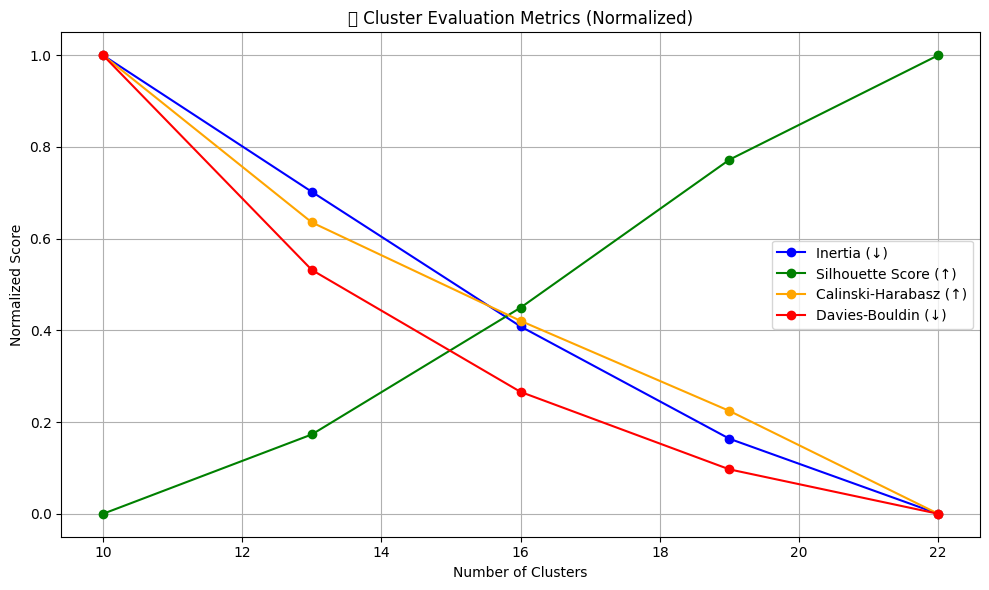

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler

# # 클러스터 개수 범위 설정
# cluster_range = range(10, 25, 3)  # 예: 2~25개

# # 결과 저장 리스트
# inertias = []
# silhouettes = []
# calinskis = []
# davies = []

# print("🔍 클러스터 수별 평가 지표 계산 중...")

# for n_clusters in cluster_range:
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     labels = kmeans.fit_predict(emb_matrix)
    
#     inertias.append(kmeans.inertia_)
#     silhouettes.append(silhouette_score(emb_matrix, labels))
#     calinskis.append(calinski_harabasz_score(emb_matrix, labels))
#     davies.append(davies_bouldin_score(emb_matrix, labels))

# # 모든 지표 리스트를 2D 배열로 정규화
# metrics = np.array([inertias, silhouettes, calinskis, davies])
# scaler = MinMaxScaler()
# metrics_scaled = scaler.fit_transform(metrics.T).T

# # 색상과 라벨 정의
# metric_labels = ['Inertia (↓)', 'Silhouette Score (↑)', 'Calinski-Harabasz (↑)', 'Davies-Bouldin (↓)']
# colors = ['blue', 'green', 'orange', 'red']

# # 📈 하나의 그래프에 모두 시각화
# plt.figure(figsize=(10, 6))
# for i, metric in enumerate(metrics_scaled):
#     plt.plot(cluster_range, metric, marker='o', label=metric_labels[i], color=colors[i])

# plt.title('📊 Cluster Evaluation Metrics (Normalized)')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Normalized Score')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


🔄 클러스터링 중...
🔄 UMAP 시각화 중...


C:\Users\wendy\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\wendy\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\wendy\AppData\Local\Temp\ipykernel_17660\1604353565.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
C:\Users\wendy\AppData\Local\Temp\ipykernel_17660\1604353565.py:71: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wendy\AppData\Local\Temp\ipykernel_17660\1604353565.py:71: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.

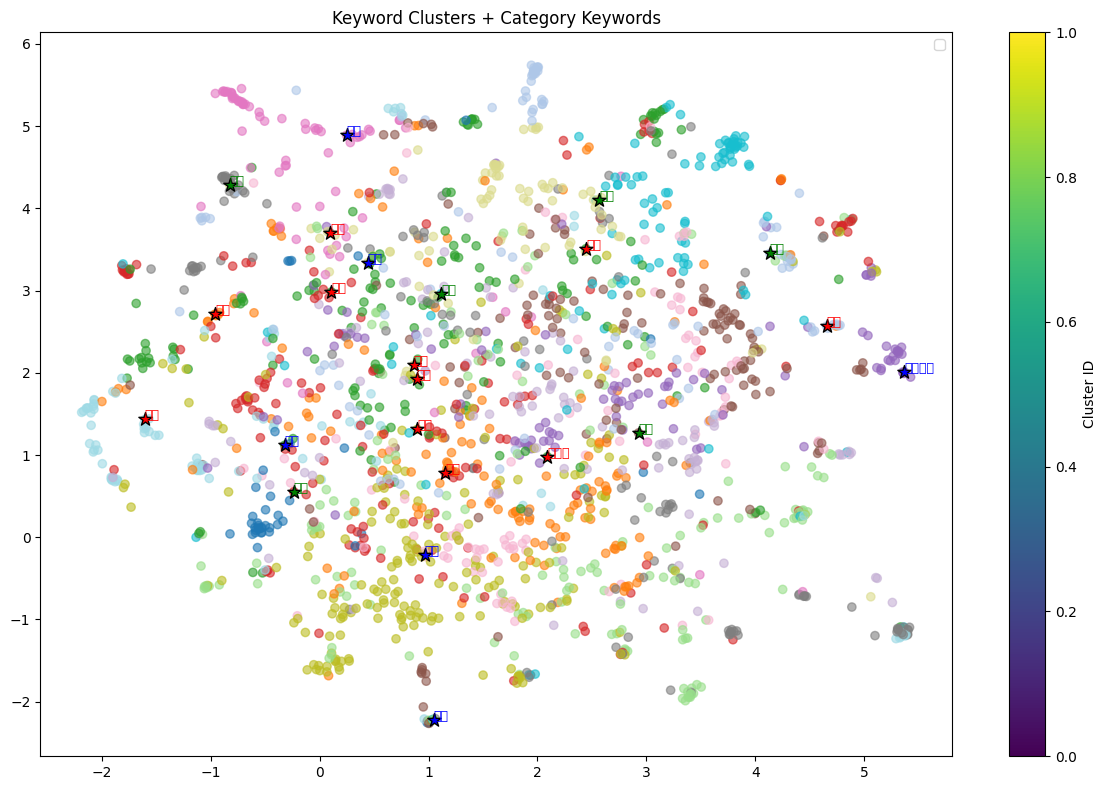

In [50]:
# ---------- 4. 클러스터링 ----------
print("🔄 클러스터링 중...")
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
labels = kmeans.fit_predict(emb_matrix)
keyword_to_cluster = {kw: int(lbl) for kw, lbl in zip(all_keywords, labels)}
cluster_to_keywords = {}
for kw, lbl in keyword_to_cluster.items():
    cluster_to_keywords.setdefault(lbl, []).append(kw)

# ---------- 5. 클러스터에 카테고리 매핑 ----------

# 카테고리 임베딩: 키워드 벡터들의 평균으로 구성
category_embeddings = {}
for cat, keywords in CATEGORY_KEYWORDS.items():
    vecs = [keyword_embeddings[kw] for kw in keywords if kw in keyword_embeddings]
    category_embeddings[cat] = np.mean(vecs, axis=0)

# Step 2: 클러스터 임베딩 생성 (클러스터에 속한 키워드들의 평균)
cluster_embeddings = {}
for cid, kws in cluster_to_keywords.items():
    vecs = [keyword_embeddings[kw] for kw in kws if kw in keyword_embeddings]
    if vecs:
        cluster_embeddings[cid] = np.mean(vecs, axis=0)
    else:
        cluster_embeddings[cid] = np.zeros(1536)

# Step 3: 클러스터 ↔ 카테고리 유사도 기반 매핑
cluster_to_category = {}
for cid, c_vec in cluster_embeddings.items():
    sims = {
        cat: cosine_similarity([c_vec], [cat_vec])[0][0]
        for cat, cat_vec in category_embeddings.items()
    }
    best_cat = max(sims, key=sims.get)
    cluster_to_category[cid] = best_cat

# ---------- 6. UMAP 시각화 (카테고리별 하이라이트 색상) ----------
print("🔄 UMAP 시각화 중...")
umap_coords = umap.UMAP(n_components=2, random_state=42).fit_transform(emb_matrix)

# 카테고리별 색상 매핑
category_colors = {
    "보장_범위": "red",
    "보장_조건": "blue",
    "보장_절차": "green"
}
# 키워드→카테고리 역매핑
kw_to_cat = {kw: cat for cat, kws in CATEGORY_KEYWORDS.items() for kw in kws}

plt.figure(figsize=(12,8))
plt.scatter(umap_coords[:,0], umap_coords[:,1], c=labels, cmap='tab20', alpha=0.6)

# 카테고리 키워드별로 서로 다른 색상으로 강조
for i, kw in enumerate(all_keywords):
    cat = kw_to_cat.get(kw)
    if cat:
        x, y = umap_coords[i]
        plt.scatter(
            x, y,
            color=category_colors[cat],
            edgecolor='black',
            s=100,
            marker='*',
            label=cat if i == 0 else None
        )
        plt.annotate(kw, (x, y), fontsize=9, fontweight='bold', color=category_colors[cat])

plt.title("Keyword Clusters + Category Keywords")
plt.colorbar(label="Cluster ID")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [51]:
cluster_to_category

{8: '보장_절차',
 11: '보장_범위',
 7: '보장_범위',
 2: '보장_범위',
 10: '보장_범위',
 3: '보장_범위',
 13: '보장_범위',
 14: '보장_절차',
 4: '보장_범위',
 1: '보장_범위',
 15: '보장_범위',
 9: '보장_조건',
 12: '보장_범위',
 6: '보장_범위',
 5: '보장_범위',
 0: '보장_범위'}

In [54]:
# ---------- 7. 청크별 분포 계산 ----------
chunk_category_distributions = []
for entry in chunk_keyword_map:
    kws = entry['keywords']
    total = len([k for k in kws if k in keyword_to_cluster]) or 1

    cat_counts = Counter(
        cluster_to_category[keyword_to_cluster[k]] for k in kws if k in keyword_to_cluster
    )

    # 📌 세 카테고리를 모두 포함해서 비율 계산
    distribution = {
        cat: round(cat_counts.get(cat, 0) / total, 3)
        for cat in CATEGORY_KEYWORDS.keys()
    }

    chunk_category_distributions.append({
        'chunk_id': entry['chunk_id'],
        'source_file': entry['source_file'],
        'category_distribution': distribution
    })

# ---------- 8. 원본에 병합 후 저장 ----------
print("🔄 원본 파일 업데이트 중...")
for file in DATA_FILES:
    data = json.load(open(file, 'r', encoding='utf-8'))
    updated = []
    for rec in data:
        cid = str(rec.get('chunk_id'))
        dist = next((d['category_distribution'] for d in chunk_category_distributions
                     if d['chunk_id']==cid and d['source_file']==file), {})
        rec['category_distribution'] = dist
        updated.append(rec)
    out = file.replace('_chunk_keywords.json', '_chunk_keywords_updated.json')
    json.dump(updated, open(out, 'w', encoding='utf-8'), ensure_ascii=False, indent=2)

# ---------- 9. 클러스터 키워드 저장 ----------
print("🔄 클러스터 키워드 저장 중...")
json.dump(cluster_to_keywords, open(f"{OUTPUT_DIR}/keyword_clusters.json", 'w', encoding='utf-8'), ensure_ascii=False, indent=2)
print("✅ 완료")

🔄 원본 파일 업데이트 중...
🔄 클러스터 키워드 저장 중...
✅ 완료


In [55]:
import json

# cluster_to_keywords: { cluster_id (int) : [keyword1, keyword2, ...], ... }

# JSON 파일로 저장
with open('cluster_keywords.json', 'w', encoding='utf-8') as f:
    json.dump(
        { str(cid): kws for cid, kws in cluster_to_keywords.items() },
        f,
        ensure_ascii=False,
        indent=2
    )


C:\Users\wendy\AppData\Local\Temp\ipykernel_5576\2890514008.py:48: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wendy\AppData\Local\Temp\ipykernel_5576\2890514008.py:48: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wendy\AppData\Local\Temp\ipykernel_5576\2890514008.py:48: UserWarning: Glyph 47700 (\N{HANGUL SYLLABLE ME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wendy\AppData\Local\Temp\ipykernel_5576\2890514008.py:48: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wendy\AppData\Local\Temp\ipykernel_5576\2890514008.py:48: UserWarning: Glyph 52768 (\N{HANGUL SYLLABLE CEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wendy\AppData\Local\Temp\ipykernel_5576\2890514008.py:48: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from font(s

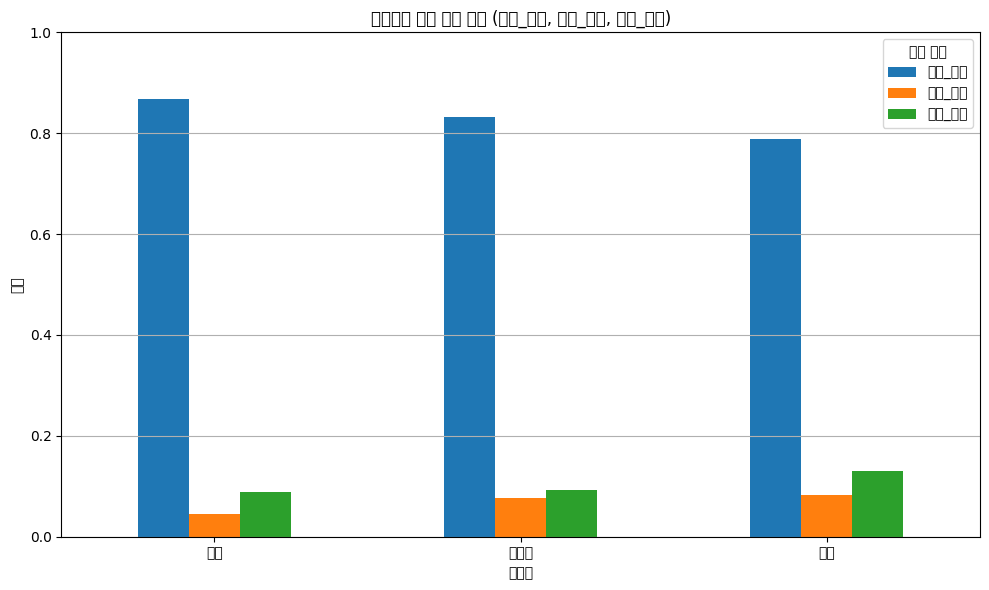

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# 파일 경로
files = {
    '한화': './hanwha_chunk_keywords_updated.json',
    '메리츠': './meritz_chunk_keywords_updated.json',
    '삼성': './samsung_chunk_keywords_updated.json'
}

# 결과를 담을 데이터프레임 초기화
distribution_data = []

# 파일별로 데이터 처리
for company, filepath in files.items():
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # 각 파일의 전체 분포 누적 계산
    total_range = total_condition = total_procedure = 0.0
    for chunk in data:
        dist = chunk['category_distribution']
        total_range += dist.get('보장_범위', 0)
        total_condition += dist.get('보장_조건', 0)
        total_procedure += dist.get('보장_절차', 0)

    count = len(data)
    distribution_data.append({
        '보험사': company,
        '보장_범위': total_range / count,
        '보장_조건': total_condition / count,
        '보장_절차': total_procedure / count
    })

# DataFrame 생성
df = pd.DataFrame(distribution_data)
df.set_index('보험사', inplace=True)

# 시각화
df.plot(kind='bar', figsize=(10, 6))
plt.title('보험사별 분류 평균 분포 (보장_범위, 보장_조건, 보장_절차)')
plt.ylabel('비율')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='분류 항목')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
import os
import time
import openai
import pinecone
from uuid import uuid4
from typing import List, Dict, Tuple
from pinecone import Pinecone, ServerlessSpec

# ==================  설정 ==================

# openai.api_key = os.getenv("OPENAI_API_KEY", "YOUR_OPENAI_API_KEY")
pc = Pinecone(
    # api_key=os.getenv("PINECONE_API_KEY", PINECONE_API)
)

INDEX_NAME = "pet-insurance-chunks"
EMBED_MODEL = "text-embedding-3-large"
SUMMARY_MODEL = "gpt-3.5-turbo"
CLASSIFY_MODEL = "gpt-3.5-turbo"
ANSWER_MODEL = "gpt-4"
VECTOR_DIM = 1536
MAX_WORKERS = 15

# ✅ 2. Index 이름 및 벡터 차원 설정
INDEX_NAME = "pet-insurance-chunks"
VECTOR_DIM = 3072

# ✅ 3. 존재하지 않으면 생성
if INDEX_NAME not in pc.list_indexes().names():
    pc.create_index(
        name=INDEX_NAME,
        dimension=VECTOR_DIM,
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )

# ✅ 4. 인덱스 연결
index = pc.Index(INDEX_NAME)

In [ ]:
from openai import OpenAI
from tqdm import tqdm  

# ========== 모델 설정 ==========
EMBED_MODEL = "text-embedding-3-large"
SUMMARY_MODEL = "gpt-3.5-turbo"

# ========== 유틸 함수 ==========
def embed_text(text: str) -> List[float]:
    """텍스트를 OpenAI 임베딩 벡터로 변환"""
    resp = openai.embeddings.create(model=EMBED_MODEL, input=[text])
    return resp.data[0].embedding

# client = OpenAI(api_key=OPENAI_API)

def summarize_raw_sentences(raw_sentences: List[str]) -> str:
    prompt = (
        "다음 반려동물 보험 약관 문장들을 1~2문장으로 요약하세요:\n\n"
        + "\n".join(raw_sentences[:5])
    )
    response = client.chat.completions.create(
        model=SUMMARY_MODEL,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2
    )
    return response.choices[0].message.content.strip()

# ========== 병렬 작업 함수 ==========
def process_chunk(chunk: Dict) -> Dict:
    cid = chunk["chunk_id"]
    company = chunk.get("company", "unknown")
    try:
        summary = summarize_raw_sentences(chunk["raw_sentences"])
        vec = embed_text(summary)

        metadata = {
            "chunk_id": cid,
            "company": company,
            "summary": summary,
            "top_keywords": chunk["top_keywords"],
            "raw_sentences": " ".join(chunk["raw_sentences"])[:5000],  # optional 길이 제한
            "보장_범위": chunk["category_distribution"].get("보장_범위", 0.0),
            "보장_조건": chunk["category_distribution"].get("보장_조건", 0.0),
            "보장_절차": chunk["category_distribution"].get("보장_절차", 0.0),
        }

        record_id = f"{company}_{cid}"
        return {"id": record_id, "vec": vec, "metadata": metadata}
    
    except Exception as e:
        print(f"❌ Chunk {cid} skipped: {e}")
        return None
    
# ========== 업로드 함수 ==========
def upsert_chunks_parallel(chunks: List[Dict]):
    print(f"\n🔄 병렬 처리로 {len(chunks)}개 chunk 업로드 시작...\n")
    results = []

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = [executor.submit(process_chunk, chunk) for chunk in chunks]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing"):
            result = future.result()
            if result:
                results.append((result["id"], result["vec"], result["metadata"]))
    if results:
        index.upsert(vectors=results)
        print(f"\n✅ Pinecone에 {len(results)}개 chunk 업로드 완료.\n")
    else:
        print("❗ 업로드할 데이터가 없습니다.")


# ========== JSON 파일에서 데이터 로딩 후 실행 ==========
def load_chunks_from_json(json_path: str) -> List[Dict]:
    with open(json_path, "r", encoding="utf-8") as f:
        return json.load(f)

In [62]:
company = "hanwha"

In [63]:
# ========== 실행 ==========
if __name__ == "__main__":
    chunk_list = load_chunks_from_json(f"{company}_chunk_keywords_updated.json")

    for chunk in chunk_list:
        if "company" not in chunk:
            chunk["company"] = company

    # 슬라이스 단위로 업로드
    batch_size = 100
    total = len(chunk_list)
    print(f"🚀 총 {total}개의 chunk를 {batch_size}개 단위로 업로드합니다.\n")

    for i in range(0, total, batch_size):
        batch = chunk_list[i:i + batch_size]
        print(f"📦 업로드 중: {i + 1} ~ {min(i + batch_size, total)}")
        upsert_chunks_parallel(batch)

🚀 총 77개의 chunk를 100개 단위로 업로드합니다.

📦 업로드 중: 1 ~ 77

🔄 병렬 처리로 77개 chunk 업로드 시작...



Processing:   0%|          | 0/77 [00:00<?, ?it/s]

Processing: 100%|██████████| 77/77 [00:09<00:00,  8.05it/s]



✅ Pinecone에 77개 chunk 업로드 완료.



In [64]:
# ================== 3. RAG 검색 및 응답 생성 ==================

# 가중치 설정: [벡터 유사도, 카테고리 일치도, 키워드 매칭도]
W_VEC, W_CAT, W_KEY = 0.5, 0.3, 0.2

def classify_question(question: str) -> str:
    prompt = (
        f"질문: \"{question}\"\n"
        "위 질문이 다음 중 어느 유형인지 하나만 골라서 정확하게 한 단어로 알려주세요:\n"
        "보장_범위\n보장_조건\n보장_절차"
    )
    resp = openai.ChatCompletion.create(
        model=CLASSIFY_MODEL,
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return resp.choices[0].message.content.strip()

def compute_keyword_score(keywords: List[str], question: str) -> float:
    matched = sum(1 for kw in keywords if kw in question)
    return matched / len(keywords) if keywords else 0.0

def retrieve_top_chunks(
    question: str,
    top_k_per_company: int = 10,
    search_k: int = 100
) -> Tuple[List[Dict], str]:
    # 1) 질의 유형 분류
    q_type = classify_question(question)

    # 2) 질문 벡터
    q_vec = embed_text(question)

    # 3) Pinecone 검색
    resp = index.query(
        vector=q_vec,
        top_k=search_k,
        include_metadata=True
    )

    # 4) 회사별 점수 계산 및 그룹핑
    company_buckets: Dict[str, List[Tuple[float, Dict]]] = {}
    for match in resp.matches:
        md = match.metadata
        company = md.get("company", "unknown")
        vec_score = match.score
        cat_score = md["category_distribution"].get(q_type, 0.0)
        key_score = compute_keyword_score(md["top_keywords"], question)

        combined = W_VEC * vec_score + W_CAT * cat_score + W_KEY * key_score

        company_buckets.setdefault(company, []).append((combined, md))

    # 5) 회사별 상위 N개 추출
    top_chunks = []
    for comp, items in company_buckets.items():
        items.sort(key=lambda x: x[0], reverse=True)
        for _, md in items[:top_k_per_company]:
            top_chunks.append(md)

    return top_chunks, q_type

In [ ]:
import re

# ================== 3. RAG 검색 및 응답 생성 ==================

# 가중치 설정: [벡터 유사도, 카테고리 일치도, 키워드 매칭도]
W_VEC, W_CAT, W_KEY = 0.6, 0.2, 0.2

def classify_question(question: str) -> str:
    prompt = (
        f"질문: \"{question}\"\n"
        "위 질문이 다음 중 어느 유형인지 하나만 골라서 정확하게 한 단어로 알려주세요:\n"
        "보장_범위\n보장_조건\n보장_절차\n"
    )
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return response.choices[0].message.content.strip()


def compute_keyword_score(keywords: List[str], question: str) -> float:
    tokens = re.findall(r"[가-힣a-zA-Z0-9]+", question.lower())
    matched = sum(1 for kw in keywords if any(kw.lower() in token for token in tokens))
    return matched / len(keywords) if keywords else 0.0

def retrieve_top_chunks_by_company(
    question: str,
    top_k_per_company: int = 10,
    search_k: int = 100
) -> Tuple[Dict[str, List[Dict]], str]:
    q_type = classify_question(question)
    
    # print(q_type)
    
    q_vec = embed_text(question)

    resp = index.query(
        vector=q_vec,
        top_k=search_k,
        include_metadata=True
    )

    company_buckets: Dict[str, List[Tuple[float, Dict]]] = {}

    for match in resp.matches:
        md = match.metadata
        company = md.get("company", "unknown")
        vec_score = match.score
        cat_score = md.get(q_type, 0.0)
        key_score = compute_keyword_score(md["top_keywords"], question)

        combined = W_VEC * vec_score + W_CAT * cat_score + W_KEY * key_score
        company_buckets.setdefault(company, []).append((combined, md))

    top_chunks_by_company: Dict[str, List[Dict]] = {}

    for comp, items in company_buckets.items():
        items.sort(key=lambda x: x[0], reverse=True)
        top_chunks_by_company[comp] = [md for _, md in items[:top_k_per_company]]

    return top_chunks_by_company, q_type

def generate_comparative_answer(question: str) -> str:
    company_chunks, q_type = retrieve_top_chunks_by_company(question)

    # 🔹 회사별 문서 요약 정리
    company_sections = []
    for company, chunks in company_chunks.items():
        summaries = "\n".join([f"- {md['raw_sentences']}" for md in chunks])
        section = f"【{company}】\n{summaries}"
        company_sections.append(section)

    context = "\n\n".join(company_sections)
    
    # print(company_sections)

    # 🔹 프롬프트 구성
    prompt = (
        f"[질문]\n{question}\n\n"
        f"[약관 요약 - 질의유형: {q_type}]\n{context}\n\n"
        "위 약관 내용들을 참고하여 각 보험사(삼성화재, 메리츠화재, 한화보험 3사)의 보장 여부나 조건을 정리하고 비교해주세요. "
        "회사의 이름을 명확히 구분해서 요약해 주세요."
        
        
    )

    # 🔹 GPT 호출 (한 번만)
    response = client.chat.completions.create(
        model="gpt-4.1-nano",
        messages=[{"role": "user", "content": prompt}],
    )

    return response.choices[0].message.content.strip()


In [71]:
if __name__ == "__main__":
    question = "고령 반려견(예: 10살 이상)은 보험 가입이 불가능한가요?"
    result = generate_comparative_answer(question)
    print(result)

보장_조건
['【samsung】\n- 제3조 반려견 장례서비스의 제공 ① 회사는 제1조보험금의 지급사유에서 정한 보험금의 지급사유가 발생하고 보험수익 자가 반려견 장례서비스를 요청한 경우 반려견 장례서비스 제공업체를 통해 보험수익 자에게 반려견 장례서비스를 제공합니다 ② 회사는제1항의반려견장례서비스의제공시필요한비용이하반려견장례서비스 에서 대체하여 충당합니다 이 경우 회사는 반려견 장례서비스지원금을 보험수익자에 게 지급하지 않습니다 ③ 보험수익자가 제1항에서 정한 반려견 장례서비스 이외의 추가 서비스를 이용하거나 물품을 구매하는 경우에는 해당 추가비용을 반려견 장례서비스 제공업체에 별도로 부 담하여야 합니다 ④ 제1항에도 불구하고 반려견이 제4조보험금을 지급하지 않는 사유에서 정한 사유로 사망하였을 경우에는 반려견 장례서비스를 제공하지 않으며 이미 반려견 장례서비스 를 제공한 경우에는 보험수익자는 반려견 장례서비스 비용에 해당하는 금액을 반환하 여야 합니다 ⑤ 제1항에도 불구하고 보험수익자가 현금으로 지급받기를 원하거나 다음의 경우에 해 당하는 때에는 반려견 장례서비스지원금을 지급하고 반려견 장례서비스를 제공하지 않습니다 반려견 장례절차를 마친 후 사망 사실을 통보한 경우 2 반려견 장례서비스 제공업체의 폐업 등으로 반려견 장례서비스를 제공할 수 없는 경우\n- 제22조 계약의 무효 계약을 체결할 때 계약에서 정한 반려견의 나이에 미달되었거나 초과되었을 경우 계약을 무효로 하며 이미 납입한 보험료를 돌려드립니다 다만 회사의 고의 또는 과실로 계약이 무효로 된 경우와 회사가 승낙 전에 무효임을 알았거나 알 수 있었음에도 불구하고 보험 료를 반환하지 않은 경우에는 보험료를 납입한 날의 다음날부터 반환일까지의 기간에 대 하여 회사는 이 계약의 보험계약대출이율을 연단위 복리로 계산한 금액을 더하여 돌려 드립니다\n- 제24조 보험나이 등 ① 이 약관에서의 반려견의 나이는 만나이를 기준으로 합니다 ② 제1항의 만나이는 계약일 현재 반려견의 실제 만나이를 기준으로 하며 이

In [32]:
# 🐾 보장 범위 관련 질문
# 우리 강아지가 피부병 치료를 받으면 보장되나요?

# 예방접종이나 건강검진 비용도 보험으로 보장되나요?

# 중성화 수술 비용이 보장 대상인가요?

# 슬개골 탈구나 고관절 이형성증 같은 유전 질환도 보장되나요?

# 사고로 인한 골절 치료는 보장되나요?

# 암 치료나 항암제 투여도 보험 적용이 되나요?

# 반려견이 다른 동물이나 사람을 물었을 때 책임보험 보장이 있나요?

# 🚫 보장 제외 항목 관련 질문
# 기존 질병이 있는 경우에도 가입이 가능한가요?

# 미용 목적의 시술은 보험 적용이 안 되나요?

# 특정 품종은 가입이 제한되거나 보험료가 높은가요?

# 고령 반려견(예: 10살 이상)은 보험 가입이 불가능한가요?

# 보험 가입 후 며칠부터 보장이 시작되나요? (면책기간 관련)

# 💰 보험료 및 청구 관련 질문
# 월 보험료는 어떻게 계산되며, 어떤 요소에 따라 달라지나요?

# 실비보장형 보험과 정액보장형 보험의 차이는 무엇인가요?

# 병원 치료비를 청구하려면 어떤 서류가 필요한가요?

# 앱이나 온라인으로 청구 가능한가요?

# 수의사가 지정되어 있거나 제휴 병원만 이용해야 하나요?

# 🧾 기타 일반적인 질문
# 여러 마리를 키우는 경우 묶음 보험 할인이 있나요?

# 보험 해지나 변경은 어떻게 하나요?

# 반려견이 사망한 경우 보험금 지급이 되나요?

# 타인 명의의 반려견도 보험에 가입할 수 있나요?

# 보험 갱신 시 심사가 다시 필요한가요?

In [ ]:
# 🐾 보장 범위 관련 복합 질문
# 우리 강아지가 알레르기성 피부염 진단을 받고 장기 치료 중인데, 이와 관련된 약 처방 및 반복 치료비까지 보장되는지, 그리고 특정 피부 질환에 대한 보장 한도나 횟수 제한이 있는지도 궁금합니다.

# 정기 건강검진을 받으면서 예방접종과 기생충 예방 약을 함께 처방받는 경우, 보험 적용 여부와 예방 목적 비용에 대한 세부 보장 기준이 어떻게 되나요?

# 중성화 수술을 생후 6개월 전에 했는데, 만약 관련 합병증(예: 감염, 봉합 부위 이상 등) 발생 시 이 치료비까지도 보장 대상인가요?

# 슬개골 탈구 초기 진단을 받은 후 경과 관찰 중인데, 향후 수술이 필요할 경우 보험 적용이 가능한지, 유전적 질환이라는 이유로 보장에서 제외되는 건 아닌지도 함께 알고 싶습니다.

# 반려견이 산책 중 사고로 다리를 다쳐 골절 수술과 입원을 하게 되었을 때, 응급처치부터 입원비, 재활치료까지 일련의 과정이 모두 보험으로 보장되나요?

# 암 진단 후 수술 및 항암 치료를 진행할 경우, 항암제 종류에 따라 보장 범위나 약가 차이가 있는지, 그리고 암 관련 특약이 필요한지도 설명해주세요.

# 우리 개가 산책 중 다른 소형견을 물어 상해를 입혔습니다. 이런 경우 민사적 책임에 대한 보상이 가능한지, 책임보험이 자동으로 포함되는지, 별도 특약인지도 궁금합니다.

# 🚫 보장 제외 항목 관련 복합 질문
# 강아지가 가입 전 경미한 피부병 이력이 있는 경우에도 보험 가입이 가능한지, 기존 질병에 대해 어떤 기준으로 보장 제외가 적용되는지 예시와 함께 알려주세요.

# 눈물자국 제거, 발톱 다듬기, 미용을 위한 발바닥 패드 케어 등은 보험 적용이 불가능한 건가요? 미용과 치료 목적이 혼재된 시술의 경우엔 어떻게 판단되나요?

# 예민하거나 유전병 위험이 높은 특정 품종(예: 말티즈, 포메라니안 등)은 보험료가 실제로 얼마나 더 비싸며, 가입 자체가 제한되는 경우도 있는지요?

# 10살이 넘은 노령견의 경우 보험 가입이 거절되는지, 또는 가입이 되더라도 보장 범위가 축소되거나 보험료가 급격히 오르는지 궁금합니다.

# 보험 가입 후 바로 병원에 가면 보험금 청구가 안 된다고 들었는데, 면책기간이 구체적으로 얼마나 되고, 어떤 경우에 예외가 적용될 수 있는지도 알려주세요.

# 💰 보험료 및 청구 관련 복합 질문
# 소형견과 대형견, 건강 상태가 좋은 개와 기존 질병 이력이 있는 개 간의 월 보험료 차이는 얼마나 나는지, 계산 방식이 어떤 요소에 따라 결정되는지 궁금합니다.

# 실비형 보험과 정액형 보험 중 어떤 것을 선택하는 게 나은지 헷갈립니다. 병원 방문이 자주 있는 경우, 혹은 고액 진료가 우려되는 경우 각각 어떤 형태가 유리한지도 예시 중심으로 비교해주세요.

# 보험금 청구를 위해 진료비 영수증 외에 어떤 서류가 필요한지, 진단서, 진료차트 등도 반드시 제출해야 하는지 설명 부탁드립니다.

# 보험사 전용 앱을 통한 청구 절차가 복잡하지 않은지, 사진 촬영만으로 접수가 가능한지, 서류 원본 제출이 필요한 경우도 있는지 알려주세요.

# 동물병원은 자유롭게 선택할 수 있는지, 혹시 제휴 병원만 이용 가능한 보험이 있는지도 궁금합니다. 만약 제휴 병원만 가능하다면 가까운 병원 검색은 어떻게 하나요?

# 🧾 기타 일반적인 복합 질문
# 두 마리 이상의 반려견을 동시에 보험에 가입하면 보험료 할인 혜택이 있는지, 있다면 구체적으로 몇 마리부터 적용되는지요?

# 보험 가입 후 반려견의 건강상태나 생활환경이 달라져 변경을 원할 경우, 어떤 항목을 변경할 수 있고 절차가 복잡한지도 설명해주세요.

# 반려견이 사고나 질병으로 사망할 경우, 보험금이 지급되는 조건이 있는지, 단순 노환이나 자연사일 경우엔 보장되는지 알고 싶습니다.

# 가족이나 지인이 등록한 명의로 키우는 강아지의 경우, 실제 보호자가 보험에 가입하고 보험금 청구를 할 수 있는지, 명의 문제로 제한이 있는지도 궁금합니다.

# 보험 갱신 시 별도 심사가 다시 필요한지, 기존 병력이 있으면 갱신이 거절되는 경우가 있는지도 포함해 설명해 주세요.



## 심화 분석

In [ ]:
# 보험사 간 차이점 탐지 및 자동 요약
# 현재는 분포 비교 수준인데, 좀 더 고차원적인 비교로:

# 특정 키워드/카테고리의 보험사별 차이점 요약

# 예: “보장_절차 항목에서 A사는 청구 간소화에 초점을 두는 반면, B사는 서류 요건이 더 엄격함” 같은 자동 요약

In [ ]:
# {
#   "question": "반려견이 골절 수술을 받았어요. 보험 적용이 되나요?",
#   "age": "8세",
#   "breed": "포메라니안",
#   💫 "concerns": ["기존 질병", "수술 후 치료"]
# }

In [ ]:
#  질문 템플릿 제안 (자동 완성)
# 사용자가 묻기 전에 유도 질문 제시:

# 💫 “질문을 선택해보세요” or “다음 중 궁금한 내용을 골라주세요”

# ✅ 골절 관련 보장

# ✅ 유전질환 보장 여부

# ✅ 고령견 가입 가능 여부

# 선택하면 자동으로 prompt 구성됨

# ④ 문서 직접 탐색 모드
# 유저가 "XXX 키워드 포함된 원문 보여줘" 요청 시:

# 해당 키워드 포함된 chunk 원문을 그대로 제공

# 보장 약관 내용을 '근거로 제시해달라'는 요구에 대응 가능

In [43]:
from pinecone import Pinecone
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# ✅ 전체 벡터 검색 함수
def fetch_all_vectors(index, top_k=1000) -> Tuple[List[str], List[str], List[List[float]]]:
    """Pinecone에서 전체 vector 검색 (회사명, ID 포함)"""
    vectors = []
    ids = []
    companies = []
    summaries = []
    keywords = []

    # dummy vector로 전체 검색
    response = index.query(
        vector=[0.0] * 3072,  # 3072차원 dummy
        top_k=top_k,
        include_metadata=True,
        include_values=True
    )

    for match in response.matches:
        ids.append(match.id)
        vectors.append(match.values)
        companies.append(match.metadata.get("company", "unknown"))
        summaries.append(match.metadata.get("summary", ""))
        keywords.append(match.metadata.get("top_keywords", []))

    return ids, companies, vectors, summaries, keywords

# ✅ 클러스터링 및 시각화
def cluster_all_vectors(vectors: List[List[float]], companies: List[str], n_clusters=10):
    vec_array = np.array(vectors)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vec_array)

    # PCA 축소 (2D 시각화)
    reduced = PCA(n_components=2).fit_transform(vec_array)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", alpha=0.7)

    for i, company in enumerate(companies):
        plt.annotate(company[:2], (reduced[i, 0], reduced[i, 1]), fontsize=7, alpha=0.5)

    plt.title(f"🔍 전체 벡터 클러스터링 (K={n_clusters})")
    plt.xlabel("PCA-1")
    plt.ylabel("PCA-2")
    plt.grid(True)
    plt.colorbar(scatter, label="Cluster ID")
    plt.tight_layout()
    plt.show()

    return labels

In [44]:
# ✅ 실행
ids, companies, vectors, summaries, keywords = fetch_all_vectors(index, top_k=390)
print(f"🔍 불러온 벡터 수: {len(vectors)}")

🔍 불러온 벡터 수: 390


C:\Users\wendy\AppData\Local\Temp\ipykernel_23688\3610557595.py:54: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wendy\AppData\Local\Temp\ipykernel_23688\3610557595.py:54: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wendy\AppData\Local\Temp\ipykernel_23688\3610557595.py:54: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wendy\AppData\Local\Temp\ipykernel_23688\3610557595.py:54: UserWarning: Glyph 48289 (\N{HANGUL SYLLABLE BEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wendy\AppData\Local\Temp\ipykernel_23688\3610557595.py:54: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wendy\AppData\Local\Temp\ipykernel_23688\3610557595.py:54: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}

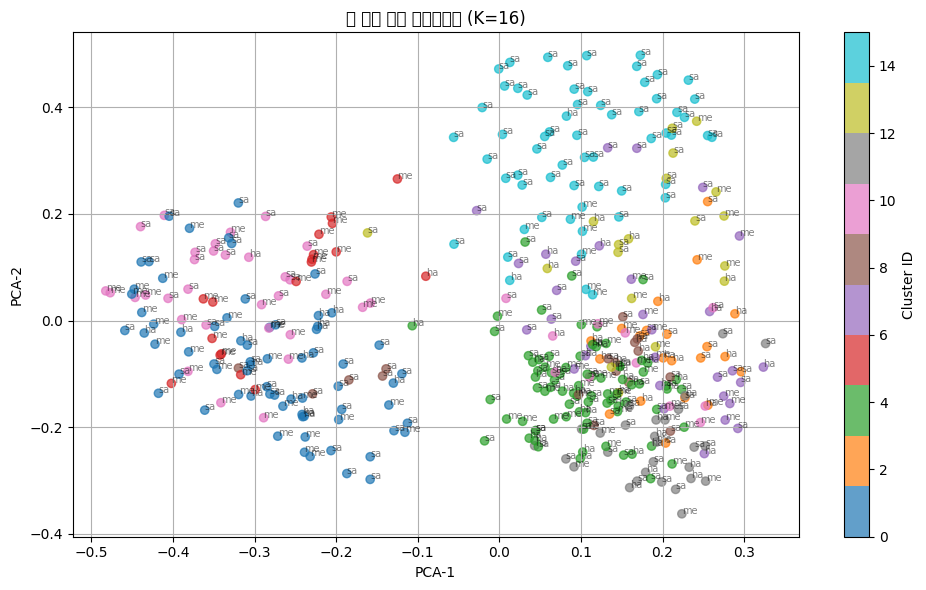

In [40]:
cluster_labels = cluster_all_vectors(vectors, companies, n_clusters=16)

🔍 클러스터 수별 평가 지표 계산 중...


C:\Users\wendy\AppData\Local\Temp\ipykernel_23688\4213960746.py:54: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wendy\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


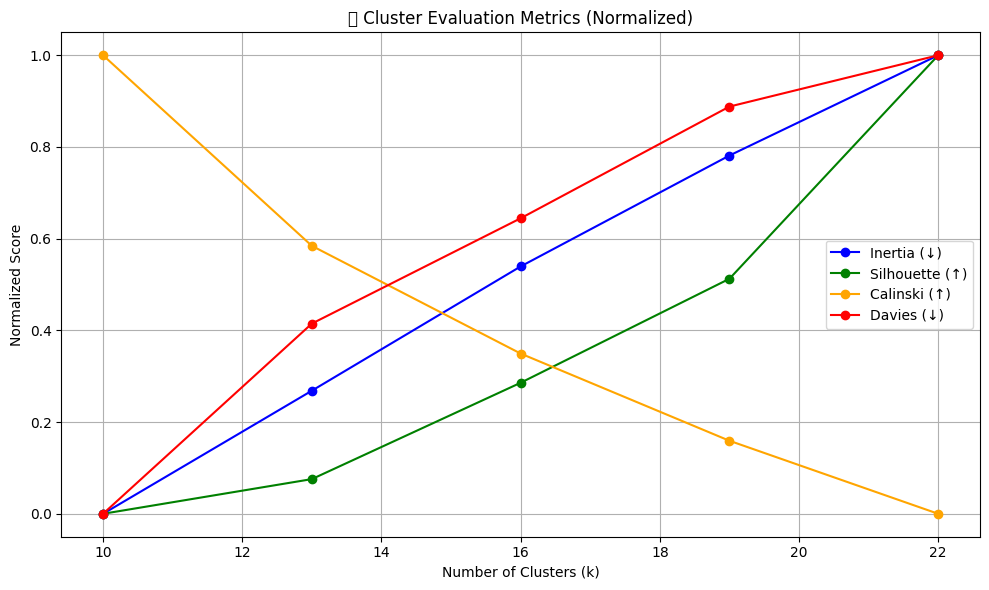

✅ 추천 클러스터 수: 22


In [35]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def evaluate_and_recommend_k(vectors: np.ndarray, cluster_range=range(5, 30, 2), plot=True):
    inertias = []
    silhouettes = []
    calinskis = []
    davies = []

    print("🔍 클러스터 수별 평가 지표 계산 중...")

    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(vectors)
        
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(vectors, labels))
        calinskis.append(calinski_harabasz_score(vectors, labels))
        davies.append(davies_bouldin_score(vectors, labels))

    # 정규화 (모두 높을수록 좋은 방향으로 맞추기 위해 inverse 처리)
    metrics = np.array([
        np.max(inertias) - np.array(inertias),               # Inertia ↓
        silhouettes,                                         # Silhouette ↑
        calinskis,                                           # Calinski ↑
        np.max(davies) - np.array(davies)                    # Davies ↓
    ])
    
    scaler = MinMaxScaler()
    metrics_scaled = scaler.fit_transform(metrics.T).T

    # 평균 점수 계산 (높을수록 좋음)
    mean_scores = metrics_scaled.mean(axis=0)
    best_index = np.argmax(mean_scores)
    best_k = cluster_range[best_index]

    # 📊 시각화
    if plot:
        labels = ['Inertia (↓)', 'Silhouette (↑)', 'Calinski (↑)', 'Davies (↓)']
        colors = ['blue', 'green', 'orange', 'red']
        plt.figure(figsize=(10, 6))
        for i, metric in enumerate(metrics_scaled):
            plt.plot(cluster_range, metric, marker='o', label=labels[i], color=colors[i])
        # plt.plot(cluster_range, mean_scores, marker='o', linestyle='--', color='black', label='Mean Score')
        # plt.axvline(best_k, color='purple', linestyle='--', label=f"Recommended k = {best_k}")
        plt.title("📊 Cluster Evaluation Metrics (Normalized)")
        plt.xlabel("Number of Clusters (k)")
        plt.ylabel("Normalized Score")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return best_k, mean_scores

# ✅ 사용 예시
best_k, scores = evaluate_and_recommend_k(emb_matrix, cluster_range=range(10, 25, 3))
print(f"✅ 추천 클러스터 수: {best_k}")

In [46]:
from collections import defaultdict

# ✅ 클러스터링 실행
def perform_clustering(vectors: List[List[float]], n_clusters: int = 16) -> List[int]:
    vec_array = np.array(vectors)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(vec_array)

# ✅ 클러스터별 결과 저장
def save_clusters_to_json(ids, companies, summaries, keywords, labels, out_path="cluster_summary.json"):
    cluster_data = defaultdict(list)

    for idx, cluster_id in enumerate(labels):
        cluster_data[str(cluster_id)].append({
            "id": ids[idx],
            "company": companies[idx],
            "summary": summaries[idx],
            "keywords": keywords[idx]
        })

    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(cluster_data, f, ensure_ascii=False, indent=2)

    print(f"✅ 클러스터 결과 저장 완료 → {out_path}")

In [47]:
cluster_labels = perform_clustering(vectors, n_clusters=16)

save_clusters_to_json(
    ids=ids,
    companies=companies,
    summaries=summaries,
    keywords=keywords,
    labels=cluster_labels,
    out_path="cluster_summary.json"
)

✅ 클러스터 결과 저장 완료 → cluster_summary.json


In [ ]:
import json
from openai import OpenAI
from tqdm import tqdm

# 🔑 OpenAI 클라이언트 준비
# client = OpenAI(api_key=OPENAI_API)

# ✅ GPT 호출 함수: 클러스터 요약 리스트 → 질문 리스트 추출
def extract_faqs_from_cluster(cluster_id: str, summaries: list, model="gpt-4.1-nano") -> list:
    joined_summaries = "\n".join(f"- {s}" for s in summaries[:30])  # 너무 길어지지 않게 제한

    prompt = (
        f"[클러스터 ID: {cluster_id}]\n"
        f"다음은 보험 약관에서 추출한 주요 요약 문장들입니다:\n\n"
        f"{joined_summaries}\n\n"
        "위 내용을 바탕으로 사람들이 자주 물을 법한 대표 질문 15가지를 한국어로 목록 형태로 작성해 주세요.\n"
        "간단명료하고 반려견 보험을 잘 몰라도 질문할법한 실질적인 질문 형식으로 정리해 주세요.\n"
    )

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.3
        )
        return response.choices[0].message.content.strip().split("\n")
    except Exception as e:
        print(f"❌ GPT 호출 실패 (cluster {cluster_id}): {e}")
        return []

# ✅ 전체 처리
def generate_faqs_for_all_clusters(json_path: str, output_path: str = "cluster_faqs.json"):
    with open(json_path, "r", encoding="utf-8") as f:
        cluster_data = json.load(f)

    faq_result = {}

    for cluster_id, items in tqdm(cluster_data.items(), desc="📦 클러스터 처리 중"):
        summaries = [item["summary"] for item in items if item.get("summary")]
        if not summaries:
            continue

        faqs = extract_faqs_from_cluster(cluster_id, summaries)
        faq_result[cluster_id] = faqs

    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(faq_result, f, ensure_ascii=False, indent=2)

    print(f"✅ 완료: 결과 저장됨 → {output_path}")


# ✅ 실행 예시
generate_faqs_for_all_clusters("cluster_summary.json")

📦 클러스터 처리 중: 100%|██████████| 16/16 [01:22<00:00,  5.17s/it]

✅ 완료: 결과 저장됨 → cluster_faqs.json


In [ ]:
import json
from openai import OpenAI
from tqdm import tqdm

# 🔑 OpenAI 클라이언트 준비
# client = OpenAI(api_key=OPENAI_API)

# ✅ GPT 호출 함수: 클러스터 요약 리스트 → 질문 리스트 추출
def extract_faqs_from_cluster(cluster_id: str, summaries: list, model="gpt-4.1-nano") -> list:
    joined_summaries = "\n".join(f"- {s}" for s in summaries[:30])  # 너무 길어지지 않게 제한

    prompt = (
        f"[클러스터 ID: {cluster_id}]\n"
        f"다음은 보험 약관에서 추출한 주요 요약 문장들입니다:\n\n"
        f"{joined_summaries}\n\n"
        "위 내용을 바탕으로 위 내용은 어떤 보험 문건에 대한 집합인지 키워드들을 나열하는 형식으로 작성해주세요.\n"
        "간단명료하고 반려견 보험을 잘 몰라도 질문할법한 실질적인 키워드들 형식으로 정리해 주세요.\n"
        
        "예시 형식 \n"
        "반려견 보험, 보험금 지급, 보험수익자, 회사 책임, 의료비용 부담, 손해 배상, 보험금 분담, 다른 보험 연계, 보험금 지급 제외 사유, 고의 과실, 자연재해, 전쟁, 핵물질, 심신장애, 출산 관련, 보험금 지급 조건, 개인정보 보호, 보험금 한도, 자기부담금, 대위권, 법률상 손해배상, 재난보험, 차량 책임보험, 중복보상, 보험금 청구, 보험 계약, 보상 한도, 보험금 지급 절차, 보험금 지급 지연, 보험금 지급 거절, 보험금 지급 영향, 보험금 포기, 보험금 지급 기준, 보험사고, 보험금 계산, 보험금 지급 책임, 보험금 지급 제외 사유, 보험금 지급 조건, 보험금 지급 방법"
    )

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.3
        )
        return response.choices[0].message.content.strip().split("\n")
    except Exception as e:
        print(f"❌ GPT 호출 실패 (cluster {cluster_id}): {e}")
        return []

# ✅ 전체 처리
def generate_faqs_for_all_clusters(json_path: str, output_path: str = "cluster_keywords.json"):
    with open(json_path, "r", encoding="utf-8") as f:
        cluster_data = json.load(f)

    faq_result = {}

    for cluster_id, items in tqdm(cluster_data.items(), desc="📦 클러스터 처리 중"):
        summaries = [item["summary"] for item in items if item.get("summary")]
        if not summaries:
            continue

        faqs = extract_faqs_from_cluster(cluster_id, summaries)
        faq_result[cluster_id] = faqs

    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(faq_result, f, ensure_ascii=False, indent=2)

    print(f"✅ 완료: 결과 저장됨 → {output_path}")


# ✅ 실행 예시
generate_faqs_for_all_clusters("cluster_summary.json")

📦 클러스터 처리 중: 100%|██████████| 16/16 [01:17<00:00,  4.84s/it]

✅ 완료: 결과 저장됨 → cluster_keywords.json


In [55]:
import json
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# 파라미터: 추출할 상위 TF-IDF 키워드 개수
TOP_K = 10

# JSON 파일 로드
with open("cluster_keywords.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# 각 클러스터를 하나의 문서로 취급 (단어는 띄어쓰기로 구분)
cluster_ids = list(data.keys())
documents = [' '.join(data[cid]) for cid in cluster_ids]

# TF-IDF 벡터라이저 초기화 및 적용
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

# 결과 저장용
cluster_keywords_tfidf = {}

# 각 클러스터에 대해 TF-IDF 점수 기준 상위 키워드 추출
for i, cid in enumerate(cluster_ids):
    row = tfidf_matrix[i].toarray().flatten()
    top_indices = row.argsort()[::-1][:TOP_K]
    top_keywords = [feature_names[idx] for idx in top_indices]
    cluster_keywords_tfidf[cid] = top_keywords

# 결과 출력 (또는 저장)
with open("cluster_top_keywords.json", "w", encoding="utf-8") as f:
    json.dump(cluster_keywords_tfidf, f, ensure_ascii=False, indent=2)

print("TF-IDF 기반 클러스터 키워드 추출 완료.")

TF-IDF 기반 클러스터 키워드 추출 완료.


## RAG 성능 비교

In [ ]:
# import os
# import json
# from multiprocessing import Pool, cpu_count
# from openai import OpenAI



# # OpenAI 클라이언트 초기화 (환경변수에 OPENAI_API_KEY 필요)
# client = OpenAI(api_key=OPENAI_API)


# # 회사 파일 목록
# company_files = {
#     "hanwha": "hanwha_chunks.txt",
#     "mertiz": "meritz_chunks.txt",
#     "samsung": "samsung_chunks.txt"
# }

# # GPT 호출 함수
# def generate_questions(chunk_text, model="gpt-4"):
#     prompt = f"""
# 다음 보험 약관 조각(chunk)을 참고하여 이 조항에서 유의미하게 나올 수 있는 보험 관련 질문 3개를 만들어줘. 각 질문은 구체적이고, 실제로 고객이 궁금해할 수 있는 내용이어야 해.

# Chunk 내용:
# \"\"\"{chunk_text}\"\"\"

# 형식:
# 1. 질문1
# 2. 질문2
# 3. 질문3
# """
#     response = client.chat.completions.create(
#         model=model,
#         messages=[{"role": "user", "content": prompt}],
#         temperature=0.3
#     )
#     content = response.choices[0].message.content.strip()
#     print("\n[GPT 응답]:")
#     print(content)
#     return content.split("\n")

# # 결과 저장 리스트
# results = []

# # 각 파일 처리
# for company, filepath in company_files.items():
#     with open(filepath, "r", encoding="utf-8") as f:
#         content = f.read()

#     chunks = content.split("Chunk ")[1:]  # "Chunk N:" 으로 시작하므로 앞 제거
#     total_chunks = len(chunks)

#     for idx, chunk in enumerate(chunks, 1):
#         header, *body_lines = chunk.strip().split("\n", 1)
#         chunk_id = header.strip(":")
#         chunk_text = body_lines[0] if body_lines else ""

#         print(f"\n[{company.upper()}] Chunk {chunk_id} 처리 중 ({idx}/{total_chunks})...")

#         try:
#             questions = generate_questions(chunk_text)
#             for q in questions:
#                 q_clean = q.strip("1234567890. ").strip()
#                 if q_clean:
#                     results.append({
#                         "question": q_clean,
#                         "chunk_id": chunk_id,
#                         "company": company
#                     })
#         except Exception as e:
#             print(f"[ERROR] {company} - Chunk {chunk_id}: {e}")

# # JSON 파일로 저장
# output_path = "insurance_questions.json"
# with open(output_path, "w", encoding="utf-8") as f:
#     json.dump(results, f, ensure_ascii=False, indent=2)

# print(f"\n✅ 질문 생성 완료. 저장 위치: {output_path}")


In [ ]:
import os
import time
import openai
import pinecone
from uuid import uuid4
from typing import List, Dict, Tuple
from pinecone import Pinecone, ServerlessSpec

import openai
import pandas as pd
import numpy as np
import json
import time
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import umap
import matplotlib.pyplot as plt
from collections import Counter
from openai import OpenAI

# ✅ OpenAI API 키 설정
# openai.api_key = OPENAI_API

# ==================  설정 ==================

# openai.api_key = os.getenv("OPENAI_API_KEY", "YOUR_OPENAI_API_KEY")
# pc = Pinecone(
#     api_key=os.getenv("PINECONE_API_KEY", PINECONE_API)
# )

# client = OpenAI(api_key=OPENAI_API)
INDEX_NAME = "pet-insurance-chunks"
EMBED_MODEL = "text-embedding-3-large"
SUMMARY_MODEL = "gpt-3.5-turbo"
CLASSIFY_MODEL = "gpt-3.5-turbo"
ANSWER_MODEL = "gpt-4"
VECTOR_DIM = 1536
MAX_WORKERS = 15

# ✅ 2. Index 이름 및 벡터 차원 설정
INDEX_NAME = "pet-insurance-chunks"
VECTOR_DIM = 3072

# ✅ 3. 존재하지 않으면 생성
if INDEX_NAME not in pc.list_indexes().names():
    pc.create_index(
        name=INDEX_NAME,
        dimension=VECTOR_DIM,
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )

# ✅ 4. 인덱스 연결
index = pc.Index(INDEX_NAME)

C:\Users\wendy\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import json
from typing import List, Tuple, Dict
import re
from openai import OpenAI
from tqdm import tqdm  
# client = OpenAI(api_key=OPENAI_API)
# 평가 함수
def evaluate_rag_accuracy(questions_data: List[Dict], weight_sets: List[Tuple[float, float, float]], top_k: int = 10):
    results = []

    for weights in weight_sets:
        W_VEC, W_CAT, W_KEY = weights
        print(f"\n🔍 Evaluating for Weights - VEC: {W_VEC}, CAT: {W_CAT}, KEY: {W_KEY}")

        hit, total = 0, 0

        for q in questions_data:
            question = q["question"]
            target_chunk_id = q["chunk_id"]
            company = q["company"]

            # retrieve
            chunks_by_company, _ = retrieve_top_chunks_by_company(
                question,
                top_k_per_company=top_k,
                search_k=100,
                W_VEC=W_VEC,
                W_CAT=W_CAT,
                W_KEY=W_KEY
            )

            retrieved_chunk_ids = [md["chunk_id"] for md in chunks_by_company.get(company, [])]

            if target_chunk_id in retrieved_chunk_ids:
                hit += 1
            total += 1

        accuracy = hit / total if total else 0
        results.append({
            "weights": {"vec": W_VEC, "cat": W_CAT, "key": W_KEY},
            "accuracy": round(accuracy, 4),
            "hits": hit,
            "total": total
        })

    return results

# ========== 모델 설정 ==========
EMBED_MODEL = "text-embedding-3-large"
SUMMARY_MODEL = "gpt-3.5-turbo"

# ========== 유틸 함수 ==========
def embed_text(text: str) -> List[float]:
    """텍스트를 OpenAI 임베딩 벡터로 변환"""
    resp = openai.embeddings.create(model=EMBED_MODEL, input=[text])
    return resp.data[0].embedding

# ========== JSON 파일에서 데이터 로딩 후 실행 ==========
def load_chunks_from_json(json_path: str) -> List[Dict]:
    with open(json_path, "r", encoding="utf-8") as f:
        return json.load(f)
    
def classify_question(question: str) -> str:
    prompt = (
        f"질문: \"{question}\"\n"
        "위 질문이 다음 중 어느 유형인지 하나만 골라서 정확하게 한 단어로 알려주세요:\n"
        "보장_범위\n보장_조건\n보장_절차"
    )
    resp = openai.ChatCompletion.create(
        model=CLASSIFY_MODEL,
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return resp.choices[0].message.content.strip()

def compute_keyword_score(keywords: List[str], question: str) -> float:
    matched = sum(1 for kw in keywords if kw in question)
    return matched / len(keywords) if keywords else 0.0

def retrieve_top_chunks(
    question: str,
    top_k_per_company: int = 10,
    search_k: int = 100
) -> Tuple[List[Dict], str]:
    # 1) 질의 유형 분류
    q_type = classify_question(question)

    # 2) 질문 벡터
    q_vec = embed_text(question)

    # 3) Pinecone 검색
    resp = index.query(
        vector=q_vec,
        top_k=search_k,
        include_metadata=True
    )

    # 4) 회사별 점수 계산 및 그룹핑
    company_buckets: Dict[str, List[Tuple[float, Dict]]] = {}
    for match in resp.matches:
        md = match.metadata
        company = md.get("company", "unknown")
        vec_score = match.score
        cat_score = md["category_distribution"].get(q_type, 0.0)
        key_score = compute_keyword_score(md["top_keywords"], question)

        combined = W_VEC * vec_score + W_CAT * cat_score + W_KEY * key_score

        company_buckets.setdefault(company, []).append((combined, md))

    # 5) 회사별 상위 N개 추출
    top_chunks = []
    for comp, items in company_buckets.items():
        items.sort(key=lambda x: x[0], reverse=True)
        for _, md in items[:top_k_per_company]:
            top_chunks.append(md)

    return top_chunks, q_type

def classify_question(question: str) -> str:
    prompt = (
        f"질문: \"{question}\"\n"
        "위 질문이 다음 중 어느 유형인지 하나만 골라서 정확하게 한 단어로 알려주세요:\n"
        "보장_범위\n보장_조건\n보장_절차\n"
    )
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return response.choices[0].message.content.strip()


def compute_keyword_score(keywords: List[str], question: str) -> float:
    tokens = re.findall(r"[가-힣a-zA-Z0-9]+", question.lower())
    matched = sum(1 for kw in keywords if any(kw.lower() in token for token in tokens))
    return matched / len(keywords) if keywords else 0.0

def retrieve_top_chunks_by_company(
    question: str,
    top_k_per_company: int = 10,
    search_k: int = 100,
    W_VEC: float = 0.6,
    W_CAT: float = 0.2,
    W_KEY: float = 0.2
) -> Tuple[Dict[str, List[Dict]], str]:
    
    q_type = classify_question(question) 
    
    # print(q_type)
    
    q_vec = embed_text(question)

    resp = index.query(
        vector=q_vec,
        top_k=search_k,
        include_metadata=True
    )

    company_buckets: Dict[str, List[Tuple[float, Dict]]] = {}

    for match in resp.matches:
        md = match.metadata
        company = md.get("company", "unknown")
        vec_score = match.score
        cat_score = md.get(q_type, 0.0)
        key_score = compute_keyword_score(md["top_keywords"], question)

        combined = W_VEC * vec_score + W_CAT * cat_score + W_KEY * key_score
        company_buckets.setdefault(company, []).append((combined, md))

    top_chunks_by_company: Dict[str, List[Dict]] = {}

    for comp, items in company_buckets.items():
        items.sort(key=lambda x: x[0], reverse=True)
        top_chunks_by_company[comp] = [md for _, md in items[:top_k_per_company]]

    return top_chunks_by_company, q_type

def generate_comparative_answer(question: str) -> str:
    company_chunks, q_type = retrieve_top_chunks_by_company(question)

    # 🔹 회사별 문서 요약 정리
    company_sections = []
    for company, chunks in company_chunks.items():
        summaries = "\n".join([f"- {md['raw_sentences']}" for md in chunks])
        section = f"【{company}】\n{summaries}"
        company_sections.append(section)

    context = "\n\n".join(company_sections)
    
    # print(company_sections)

    # 🔹 프롬프트 구성
    prompt = (
        f"[질문]\n{question}\n\n"
        f"[약관 요약 - 질의유형: {q_type}]\n{context}\n\n"
        "위 약관 내용들을 참고하여 각 보험사(삼성화재, 메리츠화재, 한화보험 3사)의 보장 여부나 조건을 정리하고 비교해주세요. "
        "회사의 이름을 명확히 구분해서 요약해 주세요."
        
        
    )

    # 🔹 GPT 호출 (한 번만)
    response = client.chat.completions.create(
        model="gpt-4.1-nano",
        messages=[{"role": "user", "content": prompt}],
    )

    return response.choices[0].message.content.strip()


In [3]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import json

def evaluate_rag_accuracy_parallel(questions_data, weight_sets, top_k=10):
    results = []

    for weights in weight_sets:
        W_VEC, W_CAT, W_KEY = weights
        print(f"\n🔍 Evaluating for Weights - VEC: {W_VEC}, CAT: {W_CAT}, KEY: {W_KEY}")

        hits = 0
        total = len(questions_data)

        def evaluate_one(q):
            question = q["question"]
            target_chunk_id = q["chunk_id"]
            company = q["company"]

            try:
                chunks_by_company, _ = retrieve_top_chunks_by_company(
                    question,
                    top_k_per_company=top_k,
                    search_k=100,
                    W_VEC=W_VEC,
                    W_CAT=W_CAT,
                    W_KEY=W_KEY
                )
                retrieved_chunk_ids = [md["chunk_id"] for md in chunks_by_company.get(company, [])]
                return target_chunk_id in retrieved_chunk_ids
            except Exception as e:
                print(f"[Error] {question[:30]}... → {e}")
                return False

        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(evaluate_one, q) for q in questions_data]
            for f in tqdm(as_completed(futures), total=total, desc=f"Weights {weights}"):
                if f.result():
                    hits += 1

        accuracy = hits / total if total else 0
        results.append({
            "weights": {"vec": W_VEC, "cat": W_CAT, "key": W_KEY},
            "accuracy": round(accuracy, 4),
            "hits": hits,
            "total": total
        })

    return results

In [5]:
if __name__ == "__main__":
    with open("insurance_questions.json", "r", encoding="utf-8") as f:
        questions_data = json.load(f)

    weight_sets = [
        # (0.6, 0.3, 0.1),
        # (0.6, 0.1, 0.3),
        (0.6, 0.0, 0.4),
        (0.6, 0.4, 0.0)
    ]

    eval_results = evaluate_rag_accuracy_parallel(questions_data, weight_sets, top_k=10)

    for res in eval_results:
        print(f"\n✅ Weights: {res['weights']}")
        print(f" - Accuracy: {res['accuracy']}")
        print(f" - Hits: {res['hits']}/{res['total']}")


🔍 Evaluating for Weights - VEC: 0.6, CAT: 0.0, KEY: 0.4


Weights (0.6, 0.0, 0.4): 100%|██████████| 1165/1165 [02:31<00:00,  7.71it/s]



🔍 Evaluating for Weights - VEC: 0.6, CAT: 0.4, KEY: 0.0


Weights (0.6, 0.4, 0.0): 100%|██████████| 1165/1165 [02:14<00:00,  8.67it/s]


✅ Weights: {'vec': 0.6, 'cat': 0.0, 'key': 0.4}
 - Accuracy: 0.6258
 - Hits: 729/1165

✅ Weights: {'vec': 0.6, 'cat': 0.4, 'key': 0.0}
 - Accuracy: 0.5485
 - Hits: 639/1165
